# Tutorial 2: Nanostring Dataset

In this tutorial, we apply S3RL to analyze FOV 014 from the Nanostring CosMx Spatial Molecular Imaging (SMI) lung cancer dataset. This dataset consists of 20 FFPE (formalin-fixed, paraffin-embedded) tissue sections derived from non-small cell lung cancer (NSCLC) samples, with high-resolution spatial transcriptomics measurements and expert-labeled cell types.

We focus on FOV 014, a representative sample containing diverse cell populations including tumor, immune, stromal, and endothelial cells. Our goal is to enhance the spatial expression data using S3RL, allowing better separation of spatial domains and improved downstream cell-cell communication analysis.

The raw and processed data for the CosMx NSCLC dataset are publicly available at:
👉 https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset/

S3RL integrates spatial coordinates, gene expression profiles, and histology-derived features through a unified graph-based framework with contrastive and hyperspherical representation learning. In this FOV, S3RL reveals sharper spatial expression boundaries and greater correspondence with known cell-type marker genes such as DCN, SRGN, EPCAM, SOX4.

**Prepare the data**

In [1]:
from Utility.tools import load_train_data
import os

dataset = 'Nanostring'
id = '014'
pixel_size = 60
img_path = os.path.join('./Img_encoder/models/', dataset, id, 'img_emb.npy')
data_path = './Data'
knn = 5

edge_index, fea, G, G_neg, gt = load_train_data(id=id, 
                                                knn=knn, 
                                                data_path=os.path.join(data_path, dataset), 
                                                img_path=img_path, 
                                                margin=pixel_size, 
                                                dataset=dataset)

**Train the model**

In [2]:
from Utility.train_w_data import train_
import yaml

cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

ari, label_pred, emb, recon = train_(edge_index, fea, G, G_neg, gt, cfg)

print(f'The final ARI is {ari}')

Training:  33%|███▎      | 489/1500 [00:18<00:38, 26.25it/s]


Reached the tolerance, early stop training at epoch 489
The final ARI is 0.9085177871448437


**Visualize the results**

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from Utility.tools import hungarian_match
import pandas as pd
import matplotlib.colors as mcolors

data = pd.read_csv(os.path.join(data_path, dataset, 'all_in_one.csv'))
gene_id = pd.read_csv(os.path.join(data_path, dataset, 'Lung9_Rep1_exprMat_file.csv')).columns[2:]
cell_type = data[data['fov'] == int(id)]['cell_type']
label_map = {'tumors': 'Tumors', 'fibroblast': 'Fibroblast', 'lymphocyte': 'Lymphocyte', 
             'Mcell': 'Myeloid', 'neutrophil': 'Neutrophil', 'endothelial': 'Endothelial', 'epithelial': 'Epithelial', 'mast': 'Mast'}
gt_map = {'tumors': 0, 'fibroblast': 1, 'lymphocyte': 2, 'Mcell': 3, 'neutrophil': 4, 'endothelial': 5, 'epithelial': 6, 'mast': 7}
loc = np.array([data[data['fov'] == int(id)]['CenterY_local_px'], data[data['fov'] == int(id)]['CenterX_local_px']]).T

full_cmap = plt.get_cmap('magma')
colors = full_cmap(np.linspace(0.1, 1.0, 256))[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

label_pred = hungarian_match(gt, label_pred).astype(np.int32)

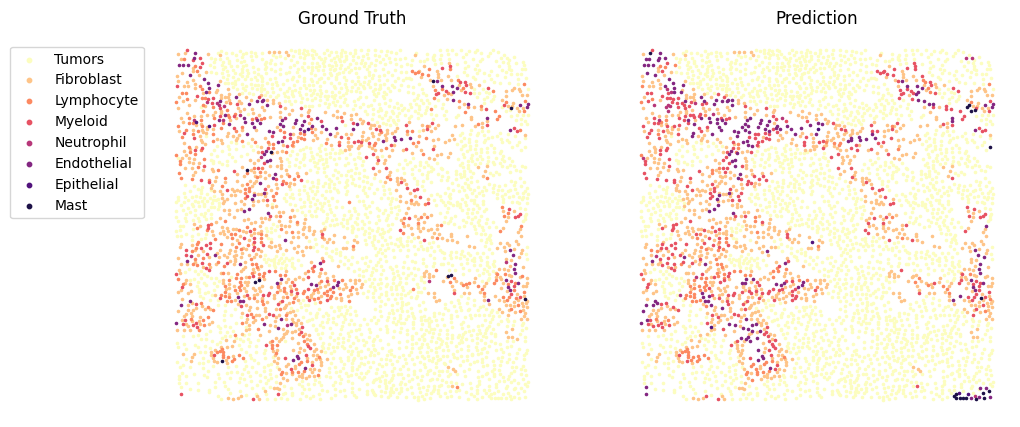

In [10]:
import matplotlib.pyplot as plt
import numpy as np

color_map = plt.get_cmap('magma')(np.linspace(0, 1, 9))[::-1]
fig, ax = plt.subplots(1, 2, figsize=(11, 5))


for i, label in enumerate(label_map.keys()):
    ax[0].scatter(loc[cell_type == label, 0], loc[cell_type == label, 1],
                color=color_map[i], s=2.5, label=label_map[label], alpha=1.0)
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.4, 0.98), fontsize=10, markerscale=2)
    
ax[0].set_xticks([])
ax[0].set_yticks([])
for spine in ax[0].spines.values():
    spine.set_visible(False)
    

for i, label in enumerate(label_map.keys()):
    cell_type_pred = gt_map[label]
    ax[1].scatter(loc[label_pred == cell_type_pred, 0], loc[label_pred == cell_type_pred, 1],
                color=color_map[i], s=2.5, label=label_map[label], alpha=1.0)

ax[1].set_xticks([])
ax[1].set_yticks([])
for spine in ax[1].spines.values():
    spine.set_visible(False)
    
ax[0].set_title('Ground Truth', fontsize=12)
ax[1].set_title('Prediction', fontsize=12)
plt.show()

Text(-0.1, 0.5, 'Enhanced')

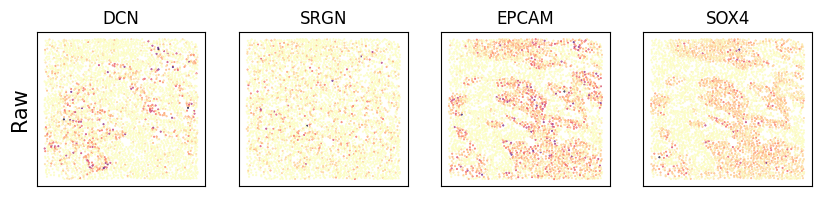

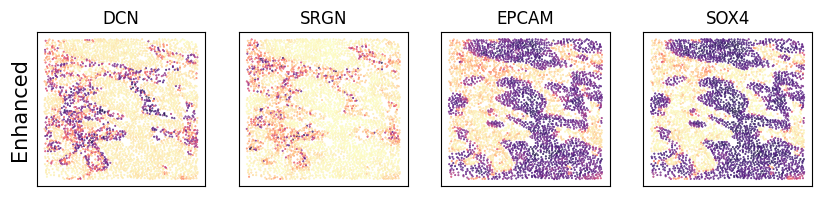

In [ ]:
import anndata

colors = plt.get_cmap('magma')(np.linspace(0.1, 1.0, 256))[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

gene_names = ['DCN','SRGN','EPCAM', 'SOX4']
adata = anndata.AnnData(X=fea.numpy())

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, gene_name in enumerate(gene_names):
    idx = gene_id.to_list().index(gene_name)
    ax[i].scatter(loc[:, 0], loc[:, 1], c=adata.X[:, idx], cmap=cmap, s=0.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(gene_name)
ax[0].text(-0.1, 0.5, 'Raw', ha='center', va='center', fontsize=15, transform=ax[0].transAxes, rotation=90)

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, gene_name in enumerate(gene_names):
    idx = gene_id.to_list().index(gene_name)
    ax[i].scatter(loc[:, 0], loc[:, 1], c=recon[:, idx], cmap=cmap, s=0.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(gene_name)
ax[1].text(-0.1, 0.5, 'Enhanced', ha='center', va='center', fontsize=15, transform=ax[0].transAxes, rotation=90)
plt.show()